## Train models on the enhanced data (with all new columns)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import configparser
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath("../data_transformation/data_transfer"))

from utils import ConnectionDetails, DataTransfer

config = configparser.ConfigParser()
config.read('../config.ini')

print(*(x[1] for x in config.items('database')))

dt = DataTransfer(ConnectionDetails(*(x[1] for x in config.items('database'))))

sql_query = """
SELECT *
FROM mart.admissions
"""

df = dt.fetch_data(sql_query)

postgresql mimic-iv_db agabitas aGaBiTaS dws-student-01.informatik.uni-mannheim.de 5432


In [3]:
df.head()

,subject_id,hadm_id,admittime,admit_daytime,admission_month,dischtime,deathtime,admission_type,admit_provider_id,admission_location,...,hematocrit_csf_max_value,hematocrit_csf_avg_value,hematocrit_csf_ref_range_lower,hematocrit_csf_ref_range_upper,hematocrit_csf_was_abnormal,hematocrit_csf_ratio_abnormal,hematocrit_csf_first_abnormal_charttime,hematocrit_csf_first_test_charttime,hematocrit_csf_last_test_charttime,hematocrit_csf_abnormal_hrs_until_discharge
0,10004113,29879900,2173-03-20 00:00:00,night,3.0,2173-03-22 14:35:00,NaT,SURGICAL SAME DAY ADMISSION,P64UQ5,PHYSICIAN REFERRAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
1,10007785,22943998,2156-05-16 01:36:00,night,5.0,2156-05-21 17:10:00,NaT,EW EMER.,P15TKT,TRANSFER FROM HOSPITAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
2,10010888,20162667,2174-01-09 22:19:00,night,1.0,2174-01-27 16:00:00,NaT,EW EMER.,P26WQF,TRANSFER FROM HOSPITAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
3,10013310,22098926,2153-06-10 11:55:00,morning,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
4,10013310,22098926,2153-06-10 11:55:00,morning,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN


In [4]:
df = pd.get_dummies(df, columns=['admit_daytime'])

df = pd.get_dummies(df, columns=['marital_status'])

df = pd.get_dummies(df, columns=['race'])

df = pd.get_dummies(df, columns=['gender'])

df = pd.get_dummies(df, columns=['anchor_year_group'])

df['icd_code_numeric'] = df['icd_code'].replace({
    r'^I61.*': 'I61',   # Match codes starting with 'I61'
    r'^I63.*': 'I63',   # Match codes starting with 'I63'
    r'^G41.*': 'G41'    # Match codes starting with 'G41'
}, regex=True)

columns_to_drop = [column for column in df.columns if any(substring in column for substring in ['range', 'charttime'])]

In [5]:
# df['los'] = df['los'] * 24

In [6]:
df

,subject_id,hadm_id,admittime,admission_month,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,...,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,gender_F,gender_M,anchor_year_group_2008 - 2010,anchor_year_group_2011 - 2013,anchor_year_group_2014 - 2016,anchor_year_group_2017 - 2019,anchor_year_group_2020 - 2022,icd_code_numeric
0,10004113,29879900,2173-03-20 00:00:00,3.0,2173-03-22 14:35:00,NaT,SURGICAL SAME DAY ADMISSION,P64UQ5,PHYSICIAN REFERRAL,HOME,...,False,False,False,True,False,False,True,False,False,I61
1,10007785,22943998,2156-05-16 01:36:00,5.0,2156-05-21 17:10:00,NaT,EW EMER.,P15TKT,TRANSFER FROM HOSPITAL,HOME,...,False,False,False,True,False,False,False,False,True,I63
2,10010888,20162667,2174-01-09 22:19:00,1.0,2174-01-27 16:00:00,NaT,EW EMER.,P26WQF,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,...,False,False,False,True,False,False,False,False,True,I63
3,10013310,22098926,2153-06-10 11:55:00,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,SKILLED NURSING FACILITY,...,False,False,True,False,False,False,False,True,False,I61
4,10013310,22098926,2153-06-10 11:55:00,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,SKILLED NURSING FACILITY,...,False,False,True,False,False,False,False,True,False,I63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6169,19985409,27293537,2154-09-21 20:49:00,9.0,2154-09-28 14:39:00,NaT,EW EMER.,P627AF,TRANSFER FROM HOSPITAL,CHRONIC/LONG TERM ACUTE CARE,...,False,False,False,True,False,False,False,True,False,I63
6170,19987702,26568899,2131-01-13 16:45:00,1.0,2131-01-23 15:00:00,NaT,OBSERVATION ADMIT,P468KA,TRANSFER FROM HOSPITAL,REHAB,...,False,False,False,True,False,False,False,True,False,I61
6171,19987702,26568899,2131-01-13 16:45:00,1.0,2131-01-23 15:00:00,NaT,OBSERVATION ADMIT,P468KA,TRANSFER FROM HOSPITAL,REHAB,...,False,False,False,True,False,False,False,True,False,I63
6172,19989126,21824927,2155-01-31 01:09:00,1.0,2155-02-03 15:47:00,NaT,URGENT,P64UQ5,TRANSFER FROM HOSPITAL,HOME,...,False,False,True,False,True,False,False,False,False,I61


In [7]:
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score, KFold


cur_df = df.copy()
X = cur_df.drop('los', axis=1)
y = cur_df['los']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


encoder = ce.BinaryEncoder(cols = [
    'first_careunit', 
    'last_careunit', 
    'admission_type',
    'admission_location',
    'discharge_location',
    'insurance',
    'language',
    'icd_code_numeric'
] , return_df = True)

encoder.fit(X_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [8]:
X_train.drop(columns=[
    'dod',
    'icd_code',
    'icd_version',
    'stay_id',
    'admit_provider_id',
    'subject_id',
    'hadm_id',

    #timestamp columns
    'intime',
    'outtime',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
    *columns_to_drop
], inplace=True, axis=1)

X_test.drop(columns=[
    'dod',
    'icd_code',
    'icd_version',
    'stay_id',
    'admit_provider_id',
    'subject_id',
    'hadm_id',
    
    #timestamp columns
    'intime',
    'outtime',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
    *columns_to_drop
], inplace=True, axis=1)

In [9]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [10]:
def fillna_tests(test_name: str, df: pd.DataFrame):
    df[f'{test_name}_min_value'].fillna(-1, inplace=True)
    df[f'{test_name}_max_value'].fillna(-1, inplace=True)
    df[f'{test_name}_avg_value'].fillna(-1, inplace=True)
    df[f'{test_name}_was_abnormal'].fillna(False, inplace=True)
    df[f'{test_name}_ratio_abnormal'].fillna(0, inplace=True)
    df[f'{test_name}_abnormal_hrs_until_discharge'].fillna(-1, inplace=True)

In [11]:
tests = [
    'sodium',
    'sodium_urine',
    'sodium_whole_blood',
    'potassium',
    'potassium_whole_blood',
    'calcium_total',
    'free_calcium',
    'magnesium',
    'glucose',
    'glucose_ascites',
    'glucose_body_fluid', 
    'glucose_csf',
    'lactate',
    'lactate_dehydrogenase_csf',
    'lactate_dehydrogenase_ld',
    'ph',
    'po2',
    'bicarbonate',
    'bicarbonate_urine',
    'calculated_bicarbonate_whole_blood',
    'inr_pt',
    'pt',
    'ptt',
    'crp',
    'white_blood_cells',
    'ammonia',
    'albumin',
    'albumin_creatine_urine',
    'creatinine',
    'creatinine_clearance',
    'creatinine_serum',
    'urea_nitrogen',
    'alt',
    'ast',
    'bilirubin',
    'bilirubin_direct',
    'bilirubin_indirect',
    'bilirubin_total',
    'ratio_hemoglobin_a1c',
    'hemoglobin',
    'hematocrit',
    'hematocrit_csf'
]

In [12]:
for test in tests:
    fillna_tests(test, X_train)
    fillna_tests(test, X_test)

In [13]:
print(X_train.columns[X_train.isnull().sum() > 0])

Index([], dtype='object')


In [14]:
print(X_test.columns[X_test.isnull().sum() > 0])

Index([], dtype='object')


<Axes: >

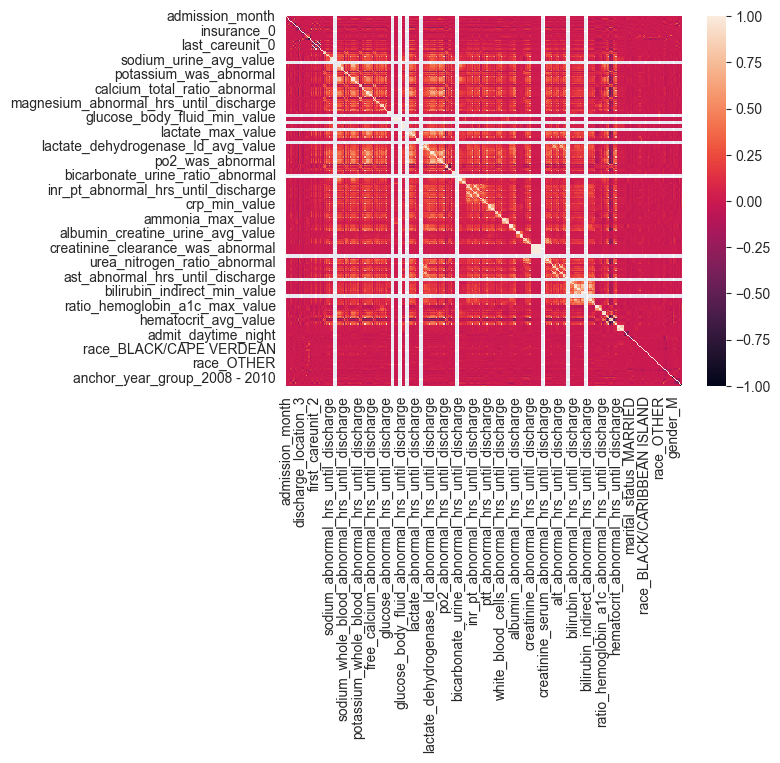

In [15]:
import seaborn as sns
%matplotlib inline

corr = X_train.corr()

sns.heatmap(corr)

In [16]:
X_train.corrwith(y_train).sort_values(ascending=False).head(21)

po2_abnormal_hrs_until_discharge                      0.465855
glucose_abnormal_hrs_until_discharge                  0.463430
white_blood_cells_abnormal_hrs_until_discharge        0.458789
hemoglobin_abnormal_hrs_until_discharge               0.456083
ph_abnormal_hrs_until_discharge                       0.452716
hematocrit_abnormal_hrs_until_discharge               0.450645
urea_nitrogen_abnormal_hrs_until_discharge            0.450566
sodium_abnormal_hrs_until_discharge                   0.450512
inr_pt_abnormal_hrs_until_discharge                   0.444758
pt_abnormal_hrs_until_discharge                       0.442618
calcium_total_abnormal_hrs_until_discharge            0.441461
bicarbonate_abnormal_hrs_until_discharge              0.438224
ptt_abnormal_hrs_until_discharge                      0.409604
potassium_abnormal_hrs_until_discharge                0.392971
free_calcium_abnormal_hrs_until_discharge             0.392717
potassium_whole_blood_abnormal_hrs_until_discharge    0

In [17]:
from ml_utils import learn_models

In [18]:
X_train.head()

,admission_month,admission_type_0,admission_type_1,admission_type_2,admission_type_3,admission_location_0,admission_location_1,admission_location_2,admission_location_3,discharge_location_0,discharge_location_1,discharge_location_2,discharge_location_3,insurance_0,insurance_1,insurance_2,language_0,language_1,language_2,language_3,language_4,hospital_expire_flag,first_careunit_0,first_careunit_1,first_careunit_2,first_careunit_3,last_careunit_0,last_careunit_1,last_careunit_2,last_careunit_3,anchor_year,sodium_min_value,sodium_max_value,sodium_avg_value,sodium_was_abnormal,sodium_ratio_abnormal,sodium_abnormal_hrs_until_discharge,sodium_urine_min_value,sodium_urine_max_value,sodium_urine_avg_value,sodium_urine_was_abnormal,sodium_urine_ratio_abnormal,sodium_urine_abnormal_hrs_until_discharge,sodium_whole_blood_min_value,sodium_whole_blood_max_value,sodium_whole_blood_avg_value,sodium_whole_blood_was_abnormal,sodium_whole_blood_ratio_abnormal,sodium_whole_blood_abnormal_hrs_until_discharge,potassium_min_value,potassium_max_value,potassium_avg_value,potassium_was_abnormal,potassium_ratio_abnormal,potassium_abnormal_hrs_until_discharge,potassium_whole_blood_min_value,potassium_whole_blood_max_value,potassium_whole_blood_avg_value,potassium_whole_blood_was_abnormal,potassium_whole_blood_ratio_abnormal,potassium_whole_blood_abnormal_hrs_until_discharge,calcium_total_min_value,calcium_total_max_value,calcium_total_avg_value,calcium_total_was_abnormal,calcium_total_ratio_abnormal,calcium_total_abnormal_hrs_until_discharge,free_calcium_min_value,free_calcium_max_value,free_calcium_avg_value,free_calcium_was_abnormal,free_calcium_ratio_abnormal,free_calcium_abnormal_hrs_until_discharge,magnesium_min_value,magnesium_max_value,magnesium_avg_value,magnesium_was_abnormal,magnesium_ratio_abnormal,magnesium_abnormal_hrs_until_discharge,glucose_min_value,glucose_max_value,glucose_avg_value,glucose_was_abnormal,glucose_ratio_abnormal,glucose_abnormal_hrs_until_discharge,glucose_ascites_min_value,glucose_ascites_max_value,glucose_ascites_avg_value,glucose_ascites_was_abnormal,glucose_ascites_ratio_abnormal,glucose_ascites_abnormal_hrs_until_discharge,glucose_body_fluid_min_value,glucose_body_fluid_max_value,glucose_body_fluid_avg_value,glucose_body_fluid_was_abnormal,glucose_body_fluid_ratio_abnormal,glucose_body_fluid_abnormal_hrs_until_discharge,glucose_csf_min_value,glucose_csf_max_value,glucose_csf_avg_value,glucose_csf_was_abnormal,glucose_csf_ratio_abnormal,glucose_csf_abnormal_hrs_until_discharge,lactate_min_value,lactate_max_value,lactate_avg_value,lactate_was_abnormal,lactate_ratio_abnormal,lactate_abnormal_hrs_until_discharge,lactate_dehydrogenase_csf_min_value,lactate_dehydrogenase_csf_max_value,lactate_dehydrogenase_csf_avg_value,lactate_dehydrogenase_csf_was_abnormal,lactate_dehydrogenase_csf_ratio_abnormal,lactate_dehydrogenase_csf_abnormal_hrs_until_discharge,lactate_dehydrogenase_ld_min_value,lactate_dehydrogenase_ld_max_value,lactate_dehydrogenase_ld_avg_value,lactate_dehydrogenase_ld_was_abnormal,lactate_dehydrogenase_ld_ratio_abnormal,lactate_dehydrogenase_ld_abnormal_hrs_until_discharge,ph_min_value,ph_max_value,ph_avg_value,ph_was_abnormal,ph_ratio_abnormal,ph_abnormal_hrs_until_discharge,po2_min_value,po2_max_value,po2_avg_value,po2_was_abnormal,po2_ratio_abnormal,po2_abnormal_hrs_until_discharge,bicarbonate_min_value,bicarbonate_max_value,bicarbonate_avg_value,bicarbonate_was_abnormal,bicarbonate_ratio_abnormal,bicarbonate_abnormal_hrs_until_discharge,bicarbonate_urine_min_value,bicarbonate_urine_max_value,bicarbonate_urine_avg_value,bicarbonate_urine_was_abnormal,bicarbonate_urine_ratio_abnormal,bicarbonate_urine_abnormal_hrs_until_discharge,calculated_bicarbonate_whole_blood_min_value,calculated_bicarbonate_whole_blood_max_value,calculated_bicarbonate_whole_blood_avg_value,calculated_bicarbonate_whole_blood_was_abnormal,calculated_bicarbonate_whole_blood_ratio_abnormal,calculated_bicarbonate_whole_blood_abnormal_hrs_unt

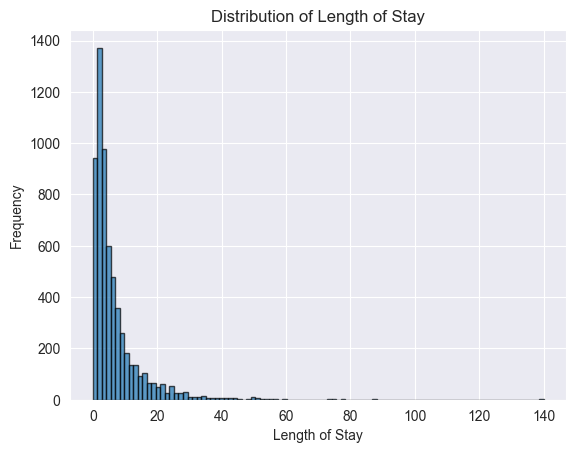

In [59]:
import matplotlib.pyplot as plt

plt.hist(df['los'], bins=100, edgecolor='k', alpha=0.7)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.show()

In [19]:
X_train.shape

(4321, 332)

In [20]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from catboost import CatBoostRegressor

initial_results = learn_models(
    models={
        'Linear Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(
            n_estimators=100, 
            max_depth=5, 
            random_state=42, 
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=100, 
            max_depth=5, 
            learning_rate=0.1, 
            objective='reg:squarederror', 
            random_state=42
        ),
        'CatBoost': CatBoostRegressor(
            iterations=100, 
            depth=5, 
            learning_rate=0.1, 
            loss_function='RMSE', 
            random_seed=42,
            verbose=False
        )
    },
    dfs=[X_train, X_test, y_train, y_test],
    folder='initial_train'
)

Training Linear Regression...
Linear Regression: RMSE = 6.934540777047273, MAE = 3.8734374564653815, R² = 0.2656018049263298
Training Random Forest...
Random Forest: RMSE = 6.389190918341178, MAE = 3.6560222902032065, R² = 0.37656968051131967
Training XGBoost...
XGBoost: RMSE = 6.299856114572757, MAE = 3.126135727181855, R² = 0.3938816262892316
Training CatBoost...
CatBoost: RMSE = 6.532483664793567, MAE = 3.540016376823766, R² = 0.3482922987768188


## Results of training

In [21]:
initial_results

,model,MAE,MSE,RMSE,R2
0,Linear Regression,3.873437,48.087856,6.934541,0.265602
1,Random Forest,3.656022,40.821761,6.389191,0.376570
2,XGBoost,3.126136,39.688187,6.299856,0.393882
3,CatBoost,3.540016,42.673343,6.532484,0.348292


In [22]:
pd.set_option('display.float_format', '{:.6f}'.format)

In [23]:
from ml_utils import FeatureExtractor

fe = FeatureExtractor(X_train.columns.tolist())

#### Linear Regression

In [24]:
fe.extract_feature_importance('initial_train', 'Linear Regression').head(20)

race_ASIAN - KOREAN                            9.330878
ratio_hemoglobin_a1c_ratio_abnormal            6.581238
ratio_hemoglobin_a1c_was_abnormal              5.906469
crp_was_abnormal                               5.781150
free_calcium_min_value                         5.506691
crp_ratio_abnormal                             5.227768
bilirubin_direct_was_abnormal                  4.413205
bilirubin_indirect_avg_value                   4.378693
free_calcium_max_value                         4.251834
bilirubin_direct_ratio_abnormal                3.551297
bilirubin_indirect_max_value                   3.527384
race_ASIAN - ASIAN INDIAN                      3.495278
po2_ratio_abnormal                             2.971116
race_AMERICAN INDIAN/ALASKA NATIVE             2.856607
po2_was_abnormal                               2.819367
race_HISPANIC/LATINO - CENTRAL AMERICAN        2.812051
ammonia_ratio_abnormal                         2.475822
bicarbonate_urine_max_value                    2

#### Random Forest Regression

In [25]:
fe.extract_feature_importance('initial_train', 'Random Forest').head(20)

po2_abnormal_hrs_until_discharge                     0.424096
glucose_abnormal_hrs_until_discharge                 0.093606
potassium_whole_blood_abnormal_hrs_until_discharge   0.043648
albumin_abnormal_hrs_until_discharge                 0.025629
first_careunit_3                                     0.021330
sodium_abnormal_hrs_until_discharge                  0.020665
sodium_avg_value                                     0.018154
free_calcium_abnormal_hrs_until_discharge            0.016371
last_careunit_3                                      0.015823
creatinine_avg_value                                 0.015479
sodium_max_value                                     0.015067
bicarbonate_max_value                                0.014156
magnesium_avg_value                                  0.013243
sodium_whole_blood_abnormal_hrs_until_discharge      0.012221
free_calcium_max_value                               0.012135
po2_ratio_abnormal                                   0.010048
ph_abnor

#### Gradient Boosting Regression

In [26]:
fe.extract_feature_importance('initial_train', 'XGBoost').head(20)

po2_abnormal_hrs_until_discharge                  0.088627
sodium_whole_blood_abnormal_hrs_until_discharge   0.031230
sodium_abnormal_hrs_until_discharge               0.028101
glucose_abnormal_hrs_until_discharge              0.025787
white_blood_cells_abnormal_hrs_until_discharge    0.024632
bicarbonate_max_value                             0.019669
ph_abnormal_hrs_until_discharge                   0.018273
anchor_year_group_2008 - 2010                     0.018085
urea_nitrogen_ratio_abnormal                      0.017680
lactate_min_value                                 0.017271
glucose_csf_max_value                             0.015901
po2_ratio_abnormal                                0.014613
lactate_dehydrogenase_ld_max_value                0.013314
first_careunit_3                                  0.013027
alt_max_value                                     0.012768
white_blood_cells_max_value                       0.012745
glucose_csf_avg_value                             0.0126

## Train after feature selection

Now I'll take 20 most important features for each algorithm and will compare the results to the original ones

In [27]:
lr_X_train, lr_X_test = fe.select_k_most_relevant_features_from_df(20, 'initial_train', 'Linear Regression', X_train, X_test)
rfr_X_train, rfr_X_test = fe.select_k_most_relevant_features_from_df(20, 'initial_train', 'Random Forest', X_train, X_test)
gbr_X_train, gbr_X_test = fe.select_k_most_relevant_features_from_df(20, 'initial_train', 'XGBoost', X_train, X_test)
cbr_X_train, cbr_X_test = fe.select_k_most_relevant_features_from_df(20, 'initial_train', 'CatBoost', X_train, X_test)

In [28]:
top_20_features_results = learn_models(
    models={
        'Linear Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(
            n_estimators=100, 
            max_depth=5, 
            random_state=42, 
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=100, 
            max_depth=5, 
            learning_rate=0.1, 
            objective='reg:squarederror', 
            random_state=42
        ),
        'CatBoost': CatBoostRegressor(
            iterations=100, 
            depth=5, 
            learning_rate=0.1, 
            loss_function='RMSE', 
            random_seed=42,
            verbose=False
        )
    },
    dfs={
        'Linear Regression': [lr_X_train, lr_X_test, y_train, y_test],
        'Random Forest': [rfr_X_train, rfr_X_test, y_train, y_test],
        'XGBoost': [gbr_X_train, gbr_X_test, y_train, y_test],
        'CatBoost': [cbr_X_train, cbr_X_test, y_train, y_test],
    },
    folder='top_20_features_train'
)

Training Linear Regression...
Linear Regression: RMSE = 7.725213868943661, MAE = 4.5526298775536285, R² = 0.0885828187068991
Training Random Forest...
Random Forest: RMSE = 6.40875453234164, MAE = 3.667294343584329, R² = 0.37274596539105864
Training XGBoost...
XGBoost: RMSE = 6.582127227718029, MAE = 3.45322162781581, R² = 0.33834936512791736
Training CatBoost...
CatBoost: RMSE = 6.522604725712294, MAE = 3.5957021455655207, R² = 0.3502619363131614


In [29]:
top_20_features_results

,model,MAE,MSE,RMSE,R2
0,Linear Regression,4.552630,59.678929,7.725214,0.088583
1,Random Forest,3.667294,41.072135,6.408755,0.372746
2,XGBoost,3.453222,43.324399,6.582127,0.338349
3,CatBoost,3.595702,42.544372,6.522605,0.350262


In [30]:
initial_results

,model,MAE,MSE,RMSE,R2
0,Linear Regression,3.873437,48.087856,6.934541,0.265602
1,Random Forest,3.656022,40.821761,6.389191,0.376570
2,XGBoost,3.126136,39.688187,6.299856,0.393882
3,CatBoost,3.540016,42.673343,6.532484,0.348292


## Train on synthetically enhanced dataset with SMOGN

In [31]:
import smogn

train = pd.concat([X_train, y_train], axis=1)

train.columns = list(X_train.columns) + ['los']

enhanced_train = smogn.smoter(train.reset_index(drop=True), y="los", k=10, samp_method='balance')

enhanced_train_copy = enhanced_train.copy()
X_train_enhanced = enhanced_train_copy.drop('los', axis=1)
y_train_enhanced = enhanced_train_copy['los']

r_index: 100%|##########| 654/654 [00:12<00:00, 50.85it/s]


In [32]:
#fix for XGBoost
obj_types = X_train_enhanced.dtypes[X_train_enhanced.dtypes == 'object']

for obj_type in obj_types.index.values.tolist():
    X_train_enhanced = X_train_enhanced.astype({obj_type: bool})

In [33]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from catboost import CatBoostRegressor

results_enhanced = learn_models(
    models={
        'Linear Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(
            n_estimators=100,
            max_depth=5,
            random_state=42,
            n_jobs=-1,
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            objective='reg:squarederror',
            random_state=42,

        ),
        'CatBoost': CatBoostRegressor(
            iterations=100,
            depth=5,
            learning_rate=0.1,
            loss_function='MAE',
            random_seed=42,
            verbose=False
        )
    },
    dfs=[X_train_enhanced, X_test, y_train_enhanced, y_test],
    folder='initial_train_enhanced'
)

Training Linear Regression...
Linear Regression: RMSE = 9.859113981805184, MAE = 4.6331846195133775, R² = -0.48447183933945537
Training Random Forest...
Random Forest: RMSE = 7.267497350687198, MAE = 4.239014168590518, R² = 0.19338563419098687
Training XGBoost...
XGBoost: RMSE = 6.651433822013595, MAE = 3.4573102367105792, R² = 0.32434228955623146
Training CatBoost...
CatBoost: RMSE = 6.279963042284545, MAE = 3.7871783940329693, R² = 0.39770346580915317


In [34]:
results_enhanced

,model,MAE,MSE,RMSE,R2
0,Linear Regression,4.633185,97.202129,9.859114,-0.484472
1,Random Forest,4.239014,52.816518,7.267497,0.193386
2,XGBoost,3.457310,44.241572,6.651434,0.324342
3,CatBoost,3.787178,39.437936,6.279963,0.397703


### Dimensionality Reduction for Linear Regression

In [35]:
features_for_models = {}

In [36]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

lasso = Lasso(alpha=0.1, random_state=42)

rfecv_lasso = RFECV(estimator=lasso, step=1, cv=KFold(5), scoring='neg_mean_squared_error')
rfecv_lasso.fit(X_train_enhanced, y_train_enhanced)

# Results for Lasso
print(f"Optimal number of features (Lasso): {rfecv_lasso.n_features_}")
print(f"Selected features (Lasso): {X_train.columns[rfecv_lasso.support_]}")

# X_train_lasso = X_train[X_train.columns[rfecv_lasso.support_]]
X_train_lasso = rfecv_lasso.transform(X_train_enhanced)

Optimal number of features (Lasso): 85
Selected features (Lasso): Index(['admission_month', 'discharge_location_1', 'discharge_location_2',
       'insurance_2', 'hospital_expire_flag', 'first_careunit_3',
       'last_careunit_3', 'anchor_year', 'sodium_min_value',
       'sodium_max_value', 'sodium_whole_blood_min_value',
       'sodium_whole_blood_max_value', 'sodium_whole_blood_avg_value',
       'potassium_max_value', 'potassium_whole_blood_min_value',
       'calcium_total_max_value', 'free_calcium_max_value',
       'magnesium_max_value', 'magnesium_was_abnormal', 'glucose_min_value',
       'glucose_max_value', 'glucose_avg_value',
       'glucose_abnormal_hrs_until_discharge', 'glucose_ascites_min_value',
       'glucose_body_fluid_min_value', 'glucose_body_fluid_avg_value',
       'glucose_csf_min_value', 'glucose_csf_max_value',
       'glucose_csf_avg_value', 'lactate_avg_value',
       'lactate_dehydrogenase_ld_ratio_abnormal',
       'lactate_dehydrogenase_ld_abnormal_hrs

In [37]:
features_for_models['lr_lasso'] = list(X_train.columns[rfecv_lasso.support_])

In [42]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [53]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_train_enhanced, y_train_enhanced, test_size=0.2, random_state=42
)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize RFECV for feature selection
rfecv = RFECV(
    estimator=rf,
    step=1,  # Number of features to remove at each iteration
    scoring='neg_mean_squared_error',  # Use negative MSE for scoring
    cv=5,  # Number of cross-validation folds
    n_jobs=-1  # Use all available CPUs
)

# Fit RFECV
rfecv.fit(X_train_rf, y_train_rf)

# Get the selected features
selected_features = X_train_rf.columns[rfecv.support_]
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {list(selected_features)}")

# Evaluate model on test set using the selected features
X_train_rf = rfecv.transform(X_train_rf)
X_test_rf = rfecv.transform(X_test_rf)

rf.fit(X_train_rf, y_train_rf)
y_pred_rf = rf.predict(X_test_rf)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
print(f"RMSE on Test Set: {rmse}")

Optimal number of features: 69
Selected features: ['admission_month', 'first_careunit_1', 'first_careunit_3', 'last_careunit_3', 'sodium_min_value', 'sodium_max_value', 'sodium_avg_value', 'sodium_ratio_abnormal', 'sodium_abnormal_hrs_until_discharge', 'sodium_whole_blood_abnormal_hrs_until_discharge', 'potassium_avg_value', 'potassium_was_abnormal', 'potassium_abnormal_hrs_until_discharge', 'potassium_whole_blood_abnormal_hrs_until_discharge', 'calcium_total_min_value', 'calcium_total_max_value', 'calcium_total_was_abnormal', 'calcium_total_abnormal_hrs_until_discharge', 'free_calcium_max_value', 'free_calcium_abnormal_hrs_until_discharge', 'magnesium_min_value', 'magnesium_avg_value', 'glucose_min_value', 'glucose_max_value', 'glucose_avg_value', 'glucose_ratio_abnormal', 'glucose_abnormal_hrs_until_discharge', 'glucose_csf_min_value', 'glucose_csf_max_value', 'glucose_csf_avg_value', 'lactate_min_value', 'lactate_avg_value', 'lactate_abnormal_hrs_until_discharge', 'lactate_dehydroge

ValueError: Found input variables with inconsistent numbers of samples: [2854, 4321]

In [70]:
features_for_models['rf'] = list(selected_features)

In [65]:
import json

with open('data.json', 'w') as fp:
    json.dump(features_for_models, fp)

In [43]:
from sklearn.metrics import make_scorer


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Convert the RMSE function into a scorer object for scikit-learn
rmse_scorer = make_scorer(rmse, greater_is_better=False)  # Lower RMSE is better

# Create an instance of the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,       # Number of trees
    max_depth=5,            # Maximum tree depth
    learning_rate=0.1,      # Learning rate
    random_state=42         # For reproducibility
)

# Define the RFECV object with XGBoost and RMSE scoring
rfecv_xgb = RFECV(
    estimator=xgb_reg,
    step=1,                 # Number of features to remove at each iteration
    scoring=rmse_scorer,    # Use RMSE as the scoring metric
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1               # Use all available CPU cores
)

# Load your dataset (replace X and y with your data)
# X = Feature matrix
# y = Target variable
rfecv_xgb.fit(X_train_enhanced, y_train_enhanced)

features_for_models['xgb'] = list(X_train.columns[rfecv_xgb.support_])
with open('data.json', 'w') as fp:
    json.dump(features_for_models, fp)

# Print results
print(f"Optimal number of features: {rfecv_xgb.n_features_}")
print("Selected features:", X_train.columns[rfecv_xgb.support_])

Optimal number of features: 104
Selected features: Index(['admission_month', 'first_careunit_1', 'first_careunit_3',
       'last_careunit_1', 'last_careunit_3', 'anchor_year', 'sodium_max_value',
       'sodium_avg_value', 'sodium_was_abnormal',
       'sodium_abnormal_hrs_until_discharge',
       ...
       'ratio_hemoglobin_a1c_abnormal_hrs_until_discharge',
       'hemoglobin_min_value', 'hemoglobin_abnormal_hrs_until_discharge',
       'hematocrit_max_value', 'hematocrit_avg_value',
       'hematocrit_abnormal_hrs_until_discharge', 'hematocrit_csf_min_value',
       'gender_M', 'icd_code_numeric_0', 'icd_code_numeric_1'],
      dtype='object', length=104)


In [44]:
# Convert the RMSE function into a scorer object for scikit-learn
rmse_scorer = make_scorer(rmse, greater_is_better=False)  # Lower RMSE is better

# Create an instance of the CatBoost Regressor
catboost_reg = CatBoostRegressor(
    iterations=500,         # Number of boosting iterations
    depth=6,                # Depth of trees
    learning_rate=0.1,      # Learning rate
    loss_function='RMSE',   # CatBoost's built-in RMSE
    verbose=0,              # Suppress output during training
    random_seed=42          # For reproducibility
)

# Define the RFECV object with CatBoost and RMSE scoring
rfecv_cb = RFECV(
    estimator=catboost_reg,
    step=1,                 # Number of features to remove at each iteration
    scoring=rmse_scorer,    # Use RMSE as the scoring metric
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1               # Use all available CPU cores
)

# Load your dataset (replace X and y with your data)
# X = Feature matrix
# y = Target variable
rfecv_cb.fit(X_train_enhanced, y_train_enhanced)


features_for_models['cb'] = list(X_train.columns[rfecv_cb.support_])
with open('data.json', 'w') as fp:
    json.dump(features_for_models, fp)

# Print results
print(f"Optimal number of features: {rfecv_cb.n_features_}")
print("Selected features:", X_train.columns[rfecv_cb.support_])

Optimal number of features: 102
Selected features: Index(['admission_month', 'discharge_location_2', 'hospital_expire_flag',
       'first_careunit_1', 'first_careunit_3', 'last_careunit_1',
       'last_careunit_2', 'last_careunit_3', 'anchor_year', 'sodium_min_value',
       ...
       'bilirubin_total_ratio_abnormal', 'ratio_hemoglobin_a1c_max_value',
       'hemoglobin_min_value', 'hemoglobin_ratio_abnormal',
       'hemoglobin_abnormal_hrs_until_discharge', 'hematocrit_max_value',
       'hematocrit_abnormal_hrs_until_discharge', 'gender_M',
       'icd_code_numeric_0', 'icd_code_numeric_1'],
      dtype='object', length=102)


In [38]:
import json

with open('data.json') as f:
    selected_features = json.load(f)

### Hyperparameter Optimization

In [45]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np


X_train_lr_lasso_selected = X_train[selected_features['lr_lasso']]
X_test_lr_lasso_selected = X_test[selected_features['lr_lasso']]

# Define the objective function for Optuna
def objective(trial):
    # Suggest a value for alpha (regularization strength)
    alpha = trial.suggest_loguniform("alpha", 1e-5, 10.0)

    # Initialize the Lasso model with the suggested alpha
    model = Lasso(alpha=alpha, random_state=42, max_iter=10000)

    # Perform cross-validation and calculate the mean MSE
    scores = cross_val_score(
        model, X_train_lr_lasso_selected, y_train, cv=5, scoring="neg_mean_squared_error"
    )
    mean_mse = -np.mean(scores)  # Convert negative MSE to positive

    return mean_mse

# Create a study and optimize the objective function
study = optuna.create_study(direction="minimize")  # We want to minimize the MSE
study.optimize(objective, n_trials=50)

# Print the best hyperparameter value and the corresponding MSE
print("Best alpha:", study.best_params["alpha"])
print("Best MSE:", study.best_value)

# Train the final Lasso model using the best alpha
best_alpha = study.best_params["alpha"]
final_model = Lasso(alpha=best_alpha, random_state=42, max_iter=10000)
final_model.fit(X_train_lr_lasso_selected, y_train)

# Evaluate on the test set
y_pred = final_model.predict(X_test_lr_lasso_selected)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)


[I 2025-01-06 19:39:04,234] A new study created in memory with name: no-name-919c298c-2a15-40ce-935b-2c1824f504d0
[I 2025-01-06 19:39:07,746] Trial 0 finished with value: 42.024257063607266 and parameters: {'alpha': 0.42902209095567956}. Best is trial 0 with value: 42.024257063607266.
[I 2025-01-06 19:39:43,915] Trial 1 finished with value: 36.923166438653446 and parameters: {'alpha': 0.00043119199320029294}. Best is trial 1 with value: 36.923166438653446.
[I 2025-01-06 19:40:10,451] Trial 2 finished with value: 37.90224410743092 and parameters: {'alpha': 0.030100133457471444}. Best is trial 1 with value: 36.923166438653446.
[I 2025-01-06 19:40:12,303] Trial 3 finished with value: 43.71137058041751 and parameters: {'alpha': 8.102625190970452}. Best is trial 1 with value: 36.923166438653446.
[I 2025-01-06 19:40:14,270] Trial 4 finished with value: 43.74668582919201 and parameters: {'alpha': 9.08573480265924}. Best is trial 1 with value: 36.923166438653446.
[I 2025-01-06 19:40:49,342] Tr

Best alpha: 0.00018858522116704666
Best MSE: 36.692866834517204
Test MSE: 47.920368801045726


In [66]:
X_train_rf_selected = X_train[selected_features['rf']]
X_test_rf_selected = X_test[selected_features['rf']]

def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)  # Number of trees in the forest
    max_depth = trial.suggest_int("max_depth", 3, 50)  # Maximum depth of the tree
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)  # Minimum samples to split an internal node
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)  # Minimum samples required at a leaf node

    # Initialize the RandomForestRegressor with the suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # Perform cross-validation and calculate the mean MSE
    scores = cross_val_score(model, X_train_rf_selected, y_train, cv=5, scoring="neg_mean_squared_error")
    mean_mse = -np.mean(scores)  # Convert negative MSE to positive

    return mean_mse

# Create a study and optimize the objective function
study = optuna.create_study(direction="minimize")  # We want to minimize the MSE
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and the corresponding MSE
print("Best hyperparameters:", study.best_params)
print("Best MSE:", study.best_value)

# Train the final RandomForestRegressor using the best hyperparameters
rf_best_params = study.best_params
final_model = RandomForestRegressor(
    n_estimators=rf_best_params["n_estimators"],
    max_depth=rf_best_params["max_depth"],
    min_samples_split=rf_best_params["min_samples_split"],
    min_samples_leaf=rf_best_params["min_samples_leaf"],
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_rf_selected, y_train)

# Evaluate on the test set
y_pred = final_model.predict(X_test_rf_selected)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)

[I 2025-01-06 21:25:44,720] A new study created in memory with name: no-name-38638270-e87e-4fe3-886e-4df9f209a918
[I 2025-01-06 21:26:17,438] Trial 0 finished with value: 34.14970882207195 and parameters: {'n_estimators': 603, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 34.14970882207195.
[I 2025-01-06 21:26:28,932] Trial 1 finished with value: 33.713437993514674 and parameters: {'n_estimators': 250, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with value: 33.713437993514674.
[I 2025-01-06 21:26:33,817] Trial 2 finished with value: 33.83372828603145 and parameters: {'n_estimators': 110, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 1 with value: 33.713437993514674.
[I 2025-01-06 21:27:06,892] Trial 3 finished with value: 33.78845818495485 and parameters: {'n_estimators': 860, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 1 with value: 

Best hyperparameters: {'n_estimators': 997, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 2}
Best MSE: 33.51368063255295
Test MSE: 31.11355977476923


In [67]:
X_train_xgb_selected = X_train[selected_features['xgb']]
X_test_xgb_selected = X_test[selected_features['xgb']]

def objective(trial):
    # Suggest values for hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 2000),  # Number of boosting rounds
        "max_depth": trial.suggest_int("max_depth", 3, 20),  # Maximum depth of a tree
        "learning_rate": trial.suggest_float("learning_rate", 0.00001, 0.3, log=True),  # Step size shrinkage
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Fraction of samples used for training each tree
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  # Fraction of features used for training each tree
        "gamma": trial.suggest_float("gamma", 0, 5.0),  # Minimum loss reduction to make a split
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5.0),  # L1 regularization term
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5.0),  # L2 regularization term
    }

    # Initialize the XGBoost Regressor with the suggested hyperparameters
    model = xgb.XGBRegressor(
        **params,
        random_state=42,
        n_jobs=-1
    )

    # Perform cross-validation and calculate the mean MSE
    scores = cross_val_score(model, X_train_xgb_selected, y_train, cv=5, scoring="neg_mean_squared_error")
    mean_mse = -np.mean(scores)  # Convert negative MSE to positive

    return mean_mse

# Create a study and optimize the objective function
study = optuna.create_study(direction="minimize")  # We want to minimize the MSE
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and the corresponding MSE
print("Best hyperparameters:", study.best_params)
print("Best MSE:", study.best_value)

# Train the final XGBoost model using the best hyperparameters
xgb_best_params = study.best_params
final_model = xgb.XGBRegressor(
    **xgb_best_params,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_xgb_selected, y_train)

# Evaluate on the test set
y_pred = final_model.predict(X_test_xgb_selected)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)


[I 2025-01-06 21:55:20,549] A new study created in memory with name: no-name-906c984b-2c9a-454e-b76f-7867ff8d43d9
[I 2025-01-06 21:56:12,958] Trial 0 finished with value: 35.350352569941755 and parameters: {'n_estimators': 1115, 'max_depth': 17, 'learning_rate': 0.003020036031499445, 'subsample': 0.8776744712265911, 'colsample_bytree': 0.8206579451132576, 'gamma': 4.958229308489316, 'reg_alpha': 3.7048897559561795, 'reg_lambda': 2.182916444192023}. Best is trial 0 with value: 35.350352569941755.
[I 2025-01-06 21:56:20,786] Trial 1 finished with value: 39.41734867719672 and parameters: {'n_estimators': 1355, 'max_depth': 5, 'learning_rate': 0.09005174884837303, 'subsample': 0.9222043629556452, 'colsample_bytree': 0.5595273125038567, 'gamma': 4.3527676582501105, 'reg_alpha': 1.044531468371136, 'reg_lambda': 1.012805252912436}. Best is trial 0 with value: 35.350352569941755.
[I 2025-01-06 21:57:20,583] Trial 2 finished with value: 58.291756038619916 and parameters: {'n_estimators': 942, '

Best hyperparameters: {'n_estimators': 1589, 'max_depth': 11, 'learning_rate': 0.002593787366169366, 'subsample': 0.5406753962998098, 'colsample_bytree': 0.5561247498837354, 'gamma': 2.9300701341802893, 'reg_alpha': 2.6366919683963284, 'reg_lambda': 4.126148567187699}
Best MSE: 34.63423722662643
Test MSE: 31.51455668923453


In [68]:
X_train_cb_selected = X_train[selected_features['cb']]
X_test_cb_selected = X_test[selected_features['cb']]

def objective(trial):
    # Suggest values for hyperparameters
    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),  # Number of boosting rounds
        "depth": trial.suggest_int("depth", 3, 10),  # Depth of each tree
        "learning_rate": trial.suggest_float("learning_rate", 0.00001, 0.3, log=True),  # Step size shrinkage
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),  # L2 regularization coefficient
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1.0),  # Strength of bagging
        "random_strength": trial.suggest_float("random_strength", 1e-2, 10.0, log=True),  # Strength of randomness
        "border_count": trial.suggest_int("border_count", 32, 255),  # Number of bins for continuous features
        "verbose": 0,  # Disable verbosity for Optuna trials
    }

    # Initialize the CatBoost Regressor with suggested hyperparameters
    model = CatBoostRegressor(
        **params,
        random_state=42
    )

    # Perform cross-validation and calculate the mean MSE
    scores = cross_val_score(model, X_train_cb_selected, y_train, cv=5, scoring="neg_mean_squared_error")
    mean_mse = -np.mean(scores)  # Convert negative MSE to positive

    return mean_mse

# Create a study and optimize the objective function
study = optuna.create_study(direction="minimize")  # We want to minimize the MSE
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and the corresponding MSE
print("Best hyperparameters:", study.best_params)
print("Best MSE:", study.best_value)

# Train the final CatBoost model using the best hyperparameters
cb_best_params = study.best_params
final_model = CatBoostRegressor(
    **cb_best_params,
    random_state=42
)
final_model.fit(X_train, y_train, verbose=0)

# Evaluate on the test set
y_pred = final_model.predict(X_test_cb_selected)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)


[I 2025-01-06 22:37:51,580] A new study created in memory with name: no-name-59d8944c-3ea2-4caa-bbfa-0749e5ecc562
[I 2025-01-06 22:38:15,235] Trial 0 finished with value: 35.986277185374874 and parameters: {'iterations': 1853, 'depth': 6, 'learning_rate': 0.06379960135962744, 'l2_leaf_reg': 1.342330399637488, 'bagging_temperature': 0.7446314375332842, 'random_strength': 0.4044564922036149, 'border_count': 37}. Best is trial 0 with value: 35.986277185374874.
[I 2025-01-06 22:42:15,717] Trial 1 finished with value: 55.62189481904058 and parameters: {'iterations': 1603, 'depth': 10, 'learning_rate': 0.00010497292812766364, 'l2_leaf_reg': 1.4955146826071641, 'bagging_temperature': 0.871025794874692, 'random_strength': 0.3606562378349952, 'border_count': 228}. Best is trial 0 with value: 35.986277185374874.
[I 2025-01-06 22:42:44,615] Trial 2 finished with value: 38.884557807105764 and parameters: {'iterations': 1897, 'depth': 6, 'learning_rate': 0.0008121469582494521, 'l2_leaf_reg': 0.1121

Best hyperparameters: {'iterations': 250, 'depth': 5, 'learning_rate': 0.07329396717657184, 'l2_leaf_reg': 0.02964003052511124, 'bagging_temperature': 0.3935313640091468, 'random_strength': 0.025775545676567486, 'border_count': 151}
Best MSE: 34.22800035292304


CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 4 should be feature with name admission_type_3 (found insurance_2).

In [49]:
len(list(X_train_cb_selected.columns))

161

In [50]:
for k, v in zip(X_train_cb_selected, X_test_cb_selected):
    if k != v:
        print(k, v)

In [69]:
optimized_results = learn_models(
    models={
        'Linear Regression': Lasso(alpha=best_alpha),
        'Random Forest': RandomForestRegressor(
            **rf_best_params
        ),
        'XGBoost': xgb.XGBRegressor(
            **xgb_best_params
        ),
        'CatBoost': CatBoostRegressor(
            **cb_best_params
        )
    },
    dfs={
        'Linear Regression': [X_train_lr_lasso_selected, X_test_lr_lasso_selected, y_train, y_test],
        'Random Forest': [X_train_rf_selected, X_test_rf_selected, y_train, y_test],
        'XGBoost': [X_train_xgb_selected, X_test_xgb_selected, y_train, y_test],
        'CatBoost': [X_train_cb_selected, X_test_cb_selected, y_train, y_test],
    },
    folder='optimized_train'
)

Training Linear Regression...
Linear Regression: RMSE = 6.920667518743305, MAE = 3.855673966237151, R² = 0.26853734301638876
Training Random Forest...
Random Forest: RMSE = 5.583119729174149, MAE = 2.9795202818170443, R² = 0.5239527387658476
Training XGBoost...
XGBoost: RMSE = 5.630804922193468, MAE = 3.047483209190743, R² = 0.5157862124317782
Training CatBoost...
0:	learn: 7.5920142	total: 6.65ms	remaining: 1.66s
1:	learn: 7.3968573	total: 9.78ms	remaining: 1.21s
2:	learn: 7.2305183	total: 12.2ms	remaining: 1s
3:	learn: 7.0616777	total: 14.7ms	remaining: 906ms
4:	learn: 6.9045448	total: 17.9ms	remaining: 880ms
5:	learn: 6.7654658	total: 20.5ms	remaining: 834ms
6:	learn: 6.6490188	total: 23ms	remaining: 797ms
7:	learn: 6.5265211	total: 25.4ms	remaining: 767ms
8:	learn: 6.4324083	total: 28.5ms	remaining: 764ms
9:	learn: 6.3365648	total: 30.9ms	remaining: 741ms
10:	learn: 6.2509060	total: 33.1ms	remaining: 718ms
11:	learn: 6.1645258	total: 35.5ms	remaining: 703ms
12:	learn: 6.0980300	tot

In [70]:
optimized_results

,model,MAE,MSE,RMSE,R2
0,Linear Regression,3.855674,47.895639,6.920668,0.268537
1,Random Forest,2.979520,31.171226,5.583120,0.523953
2,XGBoost,3.047483,31.705964,5.630805,0.515786
3,CatBoost,3.226476,41.436947,6.437154,0.367175


In [53]:
initial_results

,model,MAE,MSE,RMSE,R2
0,Linear Regression,3.873437,48.087856,6.934541,0.265602
1,Random Forest,3.656022,40.821761,6.389191,0.376570
2,XGBoost,3.126136,39.688187,6.299856,0.393882
3,CatBoost,3.540016,42.673343,6.532484,0.348292
